In [1]:
import sys
sys.path.append('/home/daisy/geuv/code/transethnic_prs-main/')
print(sys.path)
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, enet_path
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
import transethnic_prs.model1.Model1Blk as model1blk

['/home/daisy/geuv', '/home/daisy/geuv/code/transethnic_prs-main', '/home/daisy/geuv', '/home/daisy/geuv/code/transethnic_prs-main/transethnic_prs', '/home/daisy/anaconda3/envs/transethnic_prs/lib/python37.zip', '/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7', '/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/lib-dynload', '', '/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages', '/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/IPython/extensions', '/home/daisy/.ipython', '/home/daisy/geuv/code/transethnic_prs-main/']


In [2]:
from sklearn.utils.estimator_checks import check_estimator

In [3]:
gene = 'ENSG00000100300.12'
gene_name = 'TPSO'

In [4]:
pheno_total = pd.read_csv('data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt', sep = '\t', index_col = 'TargetID')
target_pheno_total = pheno_total.loc[gene]

b_hat_eur_total = pd.read_csv('data/EUR373.gene.cis.FDR5.all.rs137.txt', sep = '\t')
b_hat_eur_total_grouped = dict(list(b_hat_eur_total.groupby('GENE_ID')))
b_hat_eur_target = b_hat_eur_total_grouped[gene]

eur_sample = pd.read_csv('data/clean/eur_'+gene_name+'_genotype.012.indv', sep = '\t', header = None)
afr_sample = pd.read_csv('data/clean/afr_'+gene_name+'_genotype.012.indv', sep = '\t',header = None)

target_pheno_eur = pd.merge(target_pheno_total, eur_sample, left_index = True, right_on = 0)
target_pheno_afr = pd.merge(target_pheno_total, afr_sample, left_index = True, right_on = 0)

eur_genotype = pd.read_csv('data/clean/eur_'+gene_name+'_genotype.012', sep = '\t', header = None, index_col = 0)
afr_genotype = pd.read_csv('data/clean/afr_'+gene_name+'_genotype.012', sep = '\t', header = None, index_col = 0)

pa = target_pheno_afr.set_index(0)
pe = target_pheno_eur.set_index(0)

sorted_eur_pheno = pd.merge(eur_sample, pe, left_on = 0 , right_index = True, how = 'left')
sorted_afr_pheno = pd.merge(afr_sample, pa, left_on = 0 , right_index = True, how = 'left')
sorted_b_hat_eur = b_hat_eur_target.sort_values(by = 'SNPpos')

X1o = eur_genotype
X2o = afr_genotype
b1_hat = sorted_b_hat_eur['rvalue']
y1o = sorted_eur_pheno[gene]
y2o = sorted_afr_pheno[gene]

In [5]:
X1 = (X1o-X1o.mean())
X2 = (X2o-X2o.mean())
y1 = (y1o-y1o.mean())
y2 = (y2o-y2o.mean())
N1 = 373
N2 = 89

In [6]:
count1 = 0
idx_valid1 = []
for idx1,x1 in enumerate(X1.std()):
    if x1==0:
        count1 +=1
    else:
        idx_valid1.append(idx1)
idx_valid2 = []
count2 = 0
for idx2,x2 in enumerate(X2.std()):
    if x2==0:
        count2 +=1
    else:
        idx_valid2.append(idx2)
print(count1)
print(count2)
print(idx_valid2)

0
0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [7]:
R1 = eur_genotype.cov()

In [8]:
X1 = np.array(X1,dtype = np.float64,order = 'C')
X1o = np.array(X1o,dtype = np.float64,order = 'C')
X2 = np.array(X2,dtype = np.float64,order = 'C')
X2o = np.array(X2o,dtype = np.float64,order = 'C')
#b1_hat = np.array(b1_hat, dtype = np.float64,order = 'C')
y1 = np.array(y1, dtype = np.float64, order = 'C')
y1o = np.array(y1o,dtype = np.float64,order = 'C')
y2 = np.array(y2, dtype = np.float64, order = 'C')
y2o = np.array(y2o,dtype = np.float64,order = 'C')
R1 = np.array(R1,dtype = np.float64, order = 'C')

In [9]:
X1 = X1[:,idx_valid2]
X2 = X2[:,idx_valid2]
X1o = X1o[:,idx_valid2]
X2o = X2o[:,idx_valid2]

In [10]:
X1 = X1/np.std(X1o, axis = 0)
X2 = X2/np.std(X2o, axis = 0)
np.isnan(X2).any(axis=0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [11]:
y1 = y1/y1o.std()
y2 = y2/y2o.std()

In [12]:
R1 = np.cov(X1.T)
D_R1 = np.diag(np.diag(R1))
R1.shape

(41, 41)

In [13]:
A1 = X1.T @ X1
A1_t = (N1-1)*R1
b1 = X1.T @ y1

In [14]:
X1 = np.array(X1,dtype = np.float64,order = 'C')
X2 = np.array(X2,dtype = np.float64,order = 'C')

In [15]:
mod1 = model1blk.Model1Blk([A1], [b1], [X2], y2)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test,y_train,y_test = train_test_split(X2,y2,test_size = 0.2,random_state = 0)

In [18]:
X_train.shape,y_train.shape

((71, 41), (71,))

In [19]:
# cross_val_score
from sklearn.model_selection import cross_val_score

In [20]:
beta_mat_en, lambda_seq_en, niters_en, tols_en, convs_en = mod1.solve_path(alpha=0.1)

In [22]:
l1_ratio = 0.1
t = time.time()
beta_mat_en, lambda_seq_en, niters_en, tols_en, convs_en = mod1.solve_path(alpha=l1_ratio) 
print(f'Run time = {time.time()-t} s')

Run time = 0.0830686092376709 s


In [23]:
# lasso 
t = time.time()
beta_mat_lasso, lambda_seq_lasso, niters_lasso, tols_lasso, convs_lasso = mod1.solve_path(alpha=1) 
print(f'Run time = {time.time()-t} s')

Run time = 0.11133766174316406 s


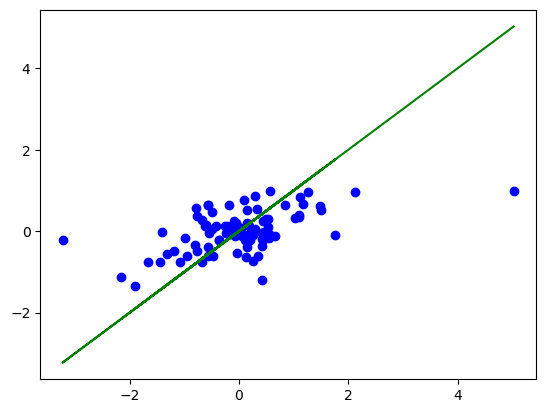

In [24]:
y2_hat_lasso = X2 @ beta_mat_lasso[:,-1:]
plt.scatter(y2, y2_hat_lasso, color = "blue")
plt.plot(y2,y2,color = 'g')
plt.text(f'R2 = %f' %)
plt.show()

In [ ]:
y2_hat_en = X2 @ beta_mat_en[:,-1:]
plt.scatter(y2, y2_hat_en, color = "blue")
plt.plot(y2,y2,color = 'g')
plt.show()

scipy.optimize

In [ ]:
from scipy import optimize

In [ ]:
beta = np.zeros(R1.shape[0])

In [ ]:
#lasso:
def lasso_fun(beta):
    term1 = beta.T @ A1 @ beta - 2 * b1.T @ beta
    term2 = np.linalg.norm(y2 - X2 @ beta)**2 #L2 norm should be squared here(least square)
    penalty = np.linalg.norm(beta, ord = 1)
    return term1 + term2 + penalty

In [ ]:
t = time.time()
result = optimize.minimize(lasso_fun, beta)
print(f'Run time = {time.time()-t} s')

In [ ]:
y2_hat_lasso_op = X2 @ result.x
plt.scatter(y2, y2_hat_lasso_op, color = "red")# red dots are scipy.optimize results
plt.scatter(y2, y2_hat_lasso, color = "blue")# blue dots are yanyu's solver results
plt.plot(y2,y2,color = 'g')
plt.show()

In [ ]:
def EN(beta):
    term1 = beta.T @ A1 @ beta - 2 * b1.T @ beta
    term2 = np.linalg.norm(y2 - X2 @ beta)**2 #L2 norm should be squared here(least square)
    ridge = np.linalg.norm(beta)**2
    lasso = np.linalg.norm(beta, ord = 1)
    penalty = 0.1 * lasso + 0.9 * ridge
    return term1 + term2 + penalty

In [ ]:
t = time.time()
result_EN = optimize.minimize(EN,beta)
print(f'Run time = {time.time()-t} s')

In [ ]:
y2_hat_en_op = X2 @ result_EN.x
plt.scatter(y2, y2_hat_en_op, color = "red")# red dots are scipy.optimize results
plt.scatter(y2, y2_hat_en, color = "blue")# blue dots are yanyu's solver results
plt.plot(y2,y2,color = 'g')
plt.show()